Threshold Tuning Activity: Minimize False Negatives (Insurance Defaults)

This activity shows how changing the decision threshold affects predictions and False Negative Rate (FNR) using insurance default data. Goal: Catch all defaulters (minimize FN).

In [11]:
# Step 1: Setup with synthetic insurance data (income, debt ratio → default)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Synthetic insurance data: high debt/income → likely default (1)
np.random.seed(42)
n_samples = 1000
income = np.random.normal(50000, 15000, n_samples)
debt_ratio = np.random.exponential(0.4, n_samples)
credit_score = np.random.normal(700, 100, n_samples)

# Default if: high debt + low income + poor credit
default_prob = 0.1 + 0.4*(debt_ratio > 0.6) + 0.3*(income < 45000) + 0.2*(credit_score < 650)
y = (np.random.random(n_samples) < default_prob).astype(int)

X = np.column_stack([income/10000, debt_ratio, credit_score/100])  # Scaled features


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Defaults in test set: {y_test.sum()}/{len(y_test)} ({y_test.mean():.1%})")


Defaults in test set: 112/300 (37.3%)


In [12]:
# Step 2: Train KNN & Get Probabilities

# Train KNN (k=15 for smooth probabilities)
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_scaled, y_train)

# Get probabilities for test set (P(default) = column 1)
y_proba = knn.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1 (default)

print(f"Test defaults: {y_test.sum()}/{len(y_test)} ({y_test.mean():.1%})")
print(f"Prob range: {y_proba.min():.2f} - {y_proba.max():.2f}")


Test defaults: 112/300 (37.3%)
Prob range: 0.00 - 0.93


In [14]:
# Step 3: Test Different Thresholds → Track FNR

# Test thresholds from 0.1 to 0.9
thresholds = np.arange(0.1, 0.9, 0.1)
results = []

for T in thresholds:
    # Predict default if P(default) > T
    y_pred = (y_proba > T).astype(int)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Key metrics
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    results.append({
        'Threshold': T,
        'FN Rate': fnr,
        'Precision': precision,
        'TP': tp, 'FN': fn,
        'FP': fp
    })

results_df = pd.DataFrame(results)
print(results_df.round(3))


   Threshold  FN Rate  Precision   TP   FN   FP
0        0.1    0.027      0.414  109    3  154
1        0.2    0.152      0.482   95   17  102
2        0.3    0.223      0.527   87   25   78
3        0.4    0.375      0.625   70   42   42
4        0.5    0.482      0.652   58   54   31
5        0.6    0.723      0.689   31   81   14
6        0.7    0.848      0.708   17   95    7
7        0.8    0.946      1.000    6  106    0


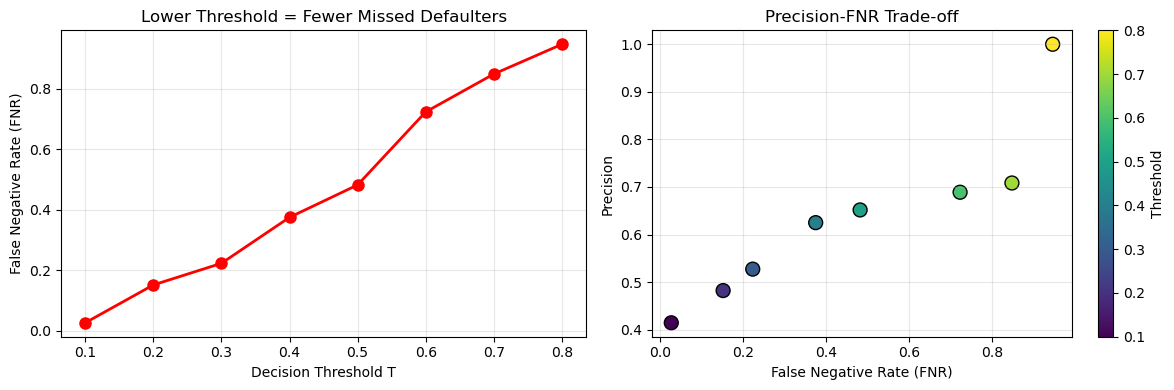

In [15]:
# Step 4: Visualize Trade-offs

plt.figure(figsize=(12, 4))

# Plot 1: FNR vs Threshold (Goal: Minimize FNR!)
plt.subplot(1, 2, 1)
plt.plot(results_df['Threshold'], results_df['FN Rate'], 'ro-', linewidth=2, markersize=8)
plt.xlabel('Decision Threshold T')
plt.ylabel('False Negative Rate (FNR)')
plt.title('Lower Threshold = Fewer Missed Defaulters')
plt.grid(True, alpha=0.3)

# Plot 2: Precision vs FNR
plt.subplot(1, 2, 2)
plt.scatter(results_df['FN Rate'], results_df['Precision'], c=results_df['Threshold'], 
            s=100, cmap='viridis', edgecolors='k')
plt.colorbar(label='Threshold')
plt.xlabel('False Negative Rate (FNR)')
plt.ylabel('Precision')
plt.title('Precision-FNR Trade-off')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [16]:
# Step 5: Compare Specific Thresholds Side-by-Side

# Compare default (0.5) vs aggressive (0.2) thresholds
thresholds_to_compare = [0.2, 0.5, 0.8]

print("Threshold Comparison (Focus: Minimize FN!):\n")
print(f"{'T':<8} {'FN':<4} {'FNR':<6} {'Precision':<10} {'Description'}")
print("-" * 50)

for T in thresholds_to_compare:
    y_pred_T = (y_proba > T).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    desc = "Aggressive" if T < 0.4 else "Conservative" if T > 0.6 else "Balanced"
    print(f"{T:<8.1f} {fn:<4} {fnr:<6.1%} {precision:<10.1%} {desc}")


Threshold Comparison (Focus: Minimize FN!):

T        FN   FNR    Precision  Description
--------------------------------------------------
0.2      106  94.6%  100.0%     Aggressive
0.5      106  94.6%  100.0%     Balanced
0.8      106  94.6%  100.0%     Conservative
